In [2]:
import zipfile
with zipfile.ZipFile("saveModel.zip","r") as zip_ref:
    zip_ref.extractall("model")

In [ ]:
# !pip install -q gdown inference-gpu supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 5.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.7/880.7 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.9/891.9 kB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.7/774.7 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 8.5 MB/s

In [ ]:
# !pip -q install  ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.8/898.8 kB 22.6 MB/s eta 0:00:00


In [10]:
import numpy as np
import supervision as sv
from ultralytics import YOLO

In [11]:
model = YOLO("model/detect/train/weights/best.pt")
SOURCE_VIDEO_PATH="the_game.mp4"

In [ ]:
# Testing Things out with the Yolo model and supervision.
# This is a quick test 


tracker = sv.ByteTrack()
box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

def callback(frame: np.ndarray, _: int) -> np.ndarray:
    results = model(frame)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = tracker.update_with_detections(detections)

    labels = [
        f"#{tracker_id} {results.names[class_id]}"
        for class_id, tracker_id
        in zip(detections.class_id, detections.tracker_id)
    ]

    annotated_frame = box_annotator.annotate(
        frame.copy(), detections=detections)
    return label_annotator.annotate(
        annotated_frame, detections=detections, labels=labels)

sv.process_video(
    source_path="the_games.mp4",
    target_path="result.mp4",
    callback=callback
)


WARNING  NMS time limit 2.050s exceeded
0: 736x1280 12 players, 2 referees, 200.0ms
Speed: 15.6ms preprocess, 200.0ms inference, 9641.8ms postprocess per image at shape (1, 3, 736, 1280)


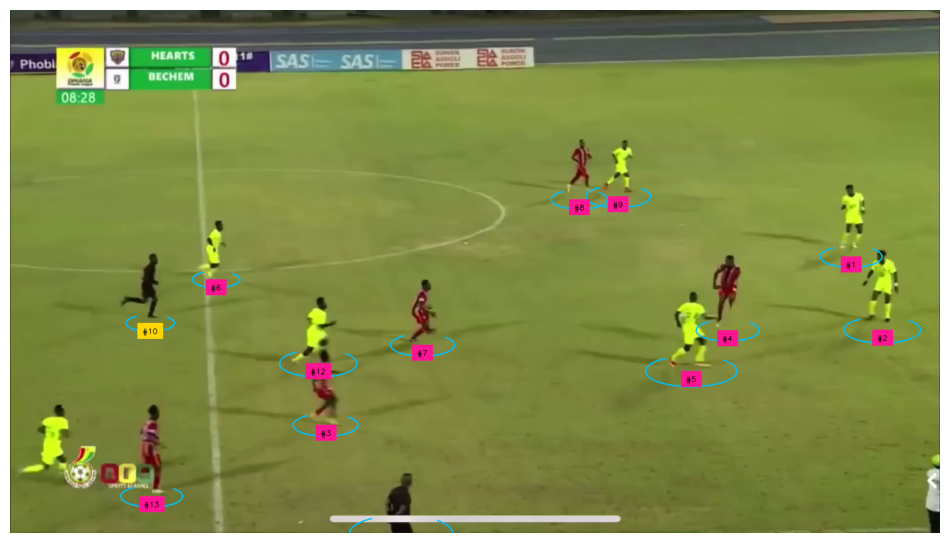

In [3]:

BALL_ID = 0


ellipse_annotator = sv.EllipseAnnotator(
    # todo 
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493','#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    # toDo
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color= sv.Color.from_hex('#000000'),
    text_position= sv.Position.BOTTOM_CENTER
)

triangle_annotator = sv.TriangleAnnotator(
    color= sv.Color.from_hex('#ffD700'),
    base=20, height=17
) 


tracker = sv.ByteTrack()
tracker.reset()


frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = model(frame)[0]
detections = sv.Detections.from_ultralytics(result)

ball_detections = detections[detections.class_id == BALL_ID] 
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
all_detections = detections[detections.class_id != BALL_ID] 
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections.class_id = all_detections.class_id - 1
all_detections = tracker.update_with_detections(all_detections)

labels = [
        f"#{tracker_id}"
        for tracker_id
        in all_detections.tracker_id
    ]

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(annotated_frame,all_detections, all_detections.confidence == 0.3)
annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections, ball_detections.confidence == 0.3)
annotated_frame = label_annotator.annotate(annotated_frame, all_detections, labels=labels)

# detections = tracker.update_with_detections(detections)

sv.plot_image(annotated_frame)

In [9]:
STRIDE = 20
PLAYER_ID = 2


def extract_crops(source_video_path: str):
    frame_generator = sv.get_video_frames_generator(source_video_path, stride=STRIDE)

    crops =[]
    for frame in frame_generator:
        result = model(frame)[0]
        detections = sv.Detections.from_ultralytics(result)
        detections = detections.with_nms(threshold=0.5, class_agnostic=True)
        detections = detections[detections.class_id == PLAYER_ID]
        crops +=[
            sv.crop_image(frame, xyxy)
            for xyxy
            in detections.xyxy
        ]
    return crops

# STRIDE = 20
# PLAYER_ID = 2


# def extract_crops(source_video_path: str):
#     frame_generator = sv.get_video_frames_generator(source_video_path, stride=STRIDE)

#     crops =[]
#     for frame in frame_generator:
#         result = model(frame)[0]
#         detections = sv.Detections.from_inference(result)
#         detections = detections.with_nms(threshold=0.5, class_agnostic=True)
#         detections = detections[detections.class_id == PLAYER_ID]
#         crops +=[
#             sv.crop_image(frame, xyxy)
#             for xyxy
#             in detections.xyxy
#         ]
#     return crops

In [12]:
crops = extract_crops(SOURCE_VIDEO_PATH)


0: 736x1280 12 players, 2 referees, 97.9ms
Speed: 12.2ms preprocess, 97.9ms inference, 326.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 2 footballs, 12 players, 1 referee, 87.4ms
Speed: 10.0ms preprocess, 87.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 football, 12 players, 1 referee, 87.1ms
Speed: 10.0ms preprocess, 87.1ms inference, 0.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 football, 11 players, 1 referee, 89.5ms
Speed: 8.2ms preprocess, 89.5ms inference, 0.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 football, 11 players, 1 referee, 90.0ms
Speed: 9.5ms preprocess, 90.0ms inference, 5.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 football, 12 players, 3 referees, 85.4ms
Speed: 14.1ms preprocess, 85.4ms inference, 0.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 12 players, 89.6ms
Speed: 9.4ms preprocess, 89.6ms inference, 0.0ms post

In [17]:
len(crops)

4794

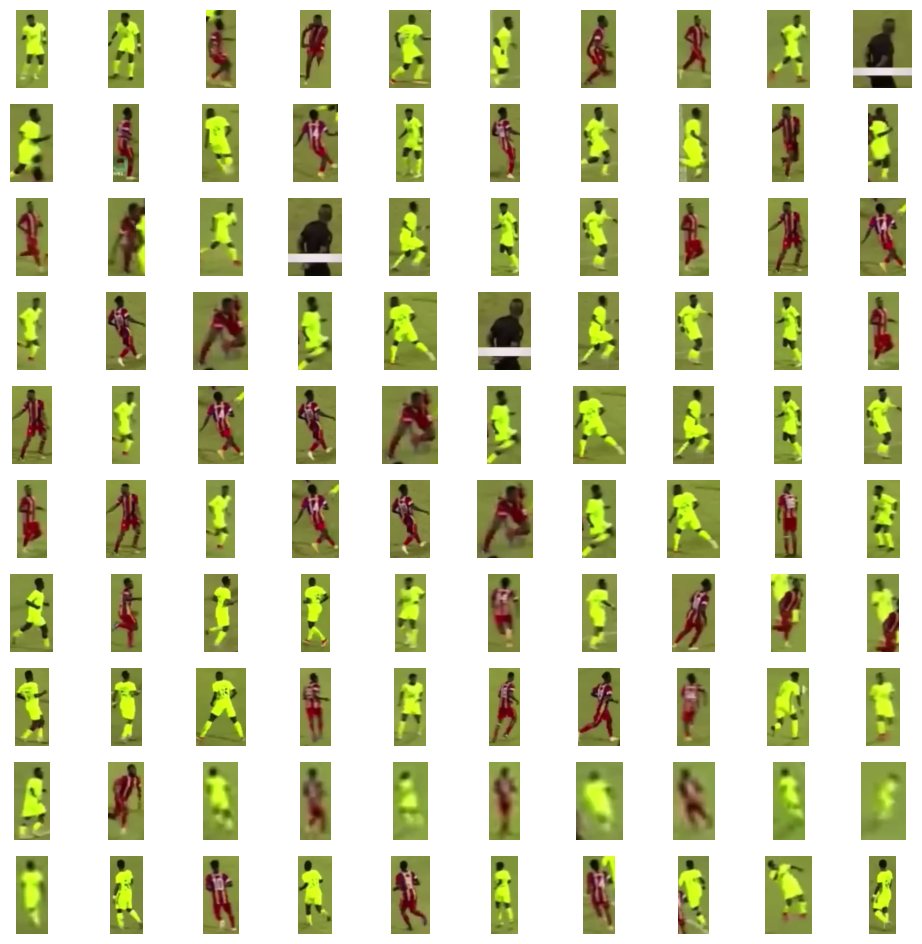

In [18]:
sv.plot_images_grid(crops[:100], grid_size=(10, 10))

In [11]:
# !pip install transformers

In [26]:
import torch
from transformers import AutoProcessor, SiglipVisionModel

In [28]:
SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBEDDING_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
EMBEDDING_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)

In [8]:
# !pip install sentencepiece

In [9]:
# !pip install ipywidgets

In [ ]:
# !pip install --upgrade protobuf
# !pip uninstall protobuf
# !pip install protobuf==4.25.5

  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.1
    Uninstalling protobuf-5.29.1:
      Successfully uninstalled protobuf-5.29.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.10.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.25.5 which is incompatible.
tensorflow 2.10.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.25.5 which is incompatible.
tensorflow-gpu 2.10.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.25.5 which is incompatible.


In [ ]:
# protobuf                           4.25.5

In [7]:
# !pip list

In [13]:
import numpy as np


from more_itertools import chunked

BATCH_SZE = 32

crops = [sv.cv2_to_pillow(crop) for crop in crops]
batches =  chunked(crops, BATCH_SZE)
data = []

with torch.no_grad():
    for batch in batches:
        inputs = EMBEDDING_PROCESSOR(images=batch, return_tensors='pt').to(DEVICE)
        outputs = EMBEDDING_MODEL(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)

data = np.concatenate(data)

In [14]:
data.shape

(4794, 768)

In [15]:
# !pip install tqdm umap-learn

In [ ]:
import umap
from sklearn.cluster import KMeans

REDUCER = umap.UMAP(n_components=3)
CLUSTERING_MODEL = KMeans(n_clusters=2)

In [18]:
projection = REDUCER.fit_transform(data)

In [19]:
projection.shape

(4794, 3)

In [20]:
clusters = CLUSTERING_MODEL.fit_predict(projection) 

In [21]:
clusters[:10]

array([0, 0, 1, 1, 0, 0, 1, 1, 0, 0])

In [23]:
team_0 = [
    crop
    for crop, cluster
    in zip(crops, clusters)
    if cluster == 0
]

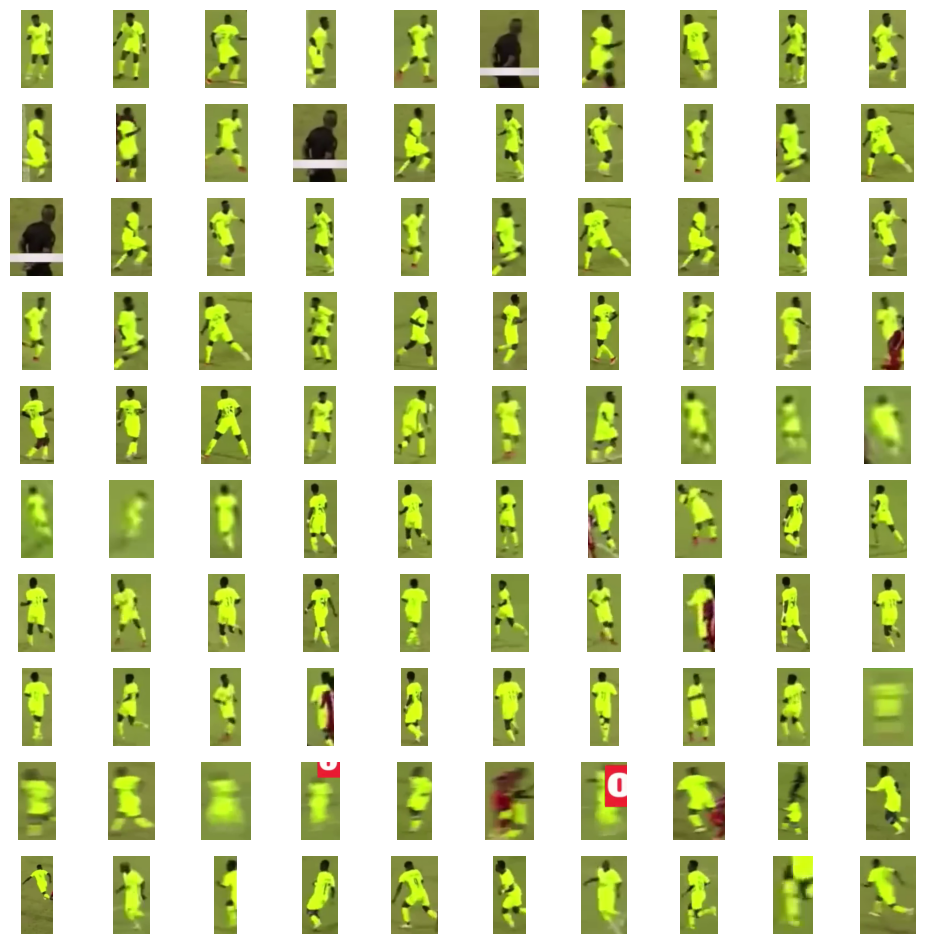

In [24]:
sv.plot_images_grid(team_0[:100], grid_size=(10, 10))

In [ ]:


SOURCE_VIDEO_PATH="the_game.mp4"
TARGET_VIDEO_PATH="the_game_result01.mp4"



tracker = sv.ByteTrack()
ellipse_annotator = sv.EllipseAnnotator(
    # todo 
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493','#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    # toDo
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color= sv.Color.from_hex('#000000'),
    text_position= sv.Position.BOTTOM_CENTER
)



triangle_annotator = sv.TriangleAnnotator(
    color= sv.Color.from_hex('#FFD700'),
    base=20, height=17
) 


tracker = sv.ByteTrack()
tracker.reset()

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# # frame = next(frame_generator)
# with video_sink:
#     for frame in frame_generator:

#         result = model(frame)[0]
#         detections = sv.Detections.from_ultralytics(result)
#         labels = [
#                 f"#{class_name} {confidence:.2f}"
#                 for class_name, confidence
#                 in zip(detections['class_name'], detections.confidence)
#             ]

#         annotated_frame = frame.copy()
#         annotated_frame = box_annotator.annotate(annotated_frame,detections)
#         annotated_frame = label_annotator.annotate(annotated_frame, detections, labels=labels)
#         video_sink.write_frame(annotated_frame)
# # detections = tracker.update_with_detections(detections)

# sv.plot_image(annotated_frame)
with video_sink:
    for frame in frame_generator:

        result = model(frame)[0]
        detections = sv.Detections.from_ultralytics(result)

        ball_detections = detections[detections.class_id == BALL_ID] 
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
        all_detections = detections[detections.class_id != BALL_ID] 
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections.class_id = all_detections.class_id - 1
        all_detections = tracker.update_with_detections(all_detections)

        labels = [
        f"#{tracker_id}"
        for tracker_id
        in all_detections.tracker_id
        ]

        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(annotated_frame,all_detections, all_detections.confidence == 0.3)
        annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections, ball_detections.confidence == 0.3)
        annotated_frame = label_annotator.annotate(annotated_frame, all_detections, labels=labels)
        video_sink.write_frame(annotated_frame)
# detections = tracker.update_with_detections(detections)

# sv.plot_image(annotated_frame)